#**MACHINE INTELLIGENCE**
##**MUSIC GENRE CLASSIFICATION**
###SNEHA MJ--------PES1UG20CS594
###THANMAYEE BS----PES1UG20CS604
###TULASI L-------PES1UG20CS607

##**1.Importing the necessary libraries**

In [ ]:
pip install AudioSegment  #used to convert .mp3 to .wav file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 3.2 MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72386 sha256=3db3bde98171c51fd1dd0ff9f7597dc542cb0b3a98dd0c2dc4b3887877538bf0
  Stored in directory: /root/.cache/pip/wheels/11/f9/67/a3158d131f57e1c0a7d8d966a707d4a2fb27567a4fe47723ad
Successfully built webrtcvad


In [ ]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten,
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


##**2.PREPROCESSING**
###Firstly the audio file .wav file is split into several 3 seconds segments

In [ ]:
from pydub import AudioSegment
i = 0
genres = 'blues classical disco metal pop rock'
genres = genres.split()
for g in genres:
  j=0
  print(f"{g}")
  for filename in os.listdir(os.path.join('/content/drive/MyDrive/Data/genres_original',f"{g}")):

    song  =  os.path.join(f'/content/drive/MyDrive/Data/genres_original/{g}',f'{filename}')
    j = j+1
    for w in range(0,10):
      i = i+1
      #print(i)
      t1 = 3*(w)*1000
      t2 = 3*(w+1)*1000
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[t1:t2]
      new.export(f'/content/audio3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

###Each genres 3 sec audio file converted to melspectogram image with help of library librosa

In [ ]:
g='reggae'
j = 0
print(g)
for filename in os.listdir(os.path.join('/content/audio3sec',f"{g}")):
  song  =  os.path.join(f'/content/audio3sec/{g}',f'{filename}')
  j = j+1
  y,sr = librosa.load(song,duration=3)
  #print(sr)
  mels = librosa.feature.melspectrogram(y=y,sr=sr)
  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
  plt.savefig(f'/content/gdrive/My Drive/spectrograms3sec/train/{g}/{g+str(j)}.png')

##**3.Splitting obtained image dataset into train and validation set**

In [ ]:
directory = "/content/drive/MyDrive/Data/miproject/training/"
#os.makedirs('/content/drive/MyDrive/Data/test3')

genres = 'blues classical disco metal pop rock'
genres = genres.split()
for g in genres:
  filenames = os.listdir(os.path.join(directory,f"{g}"))
  random.shuffle(filenames)
  test_files = filenames[0:100]
  for f in test_files:
    shutil.move(directory + f"{g}"+ "/" + f,"/content/drive/MyDrive/Data/miproject/testing/" + f"{g}")

In [ ]:
train_dir = "/content/drive/My Drive/Data/miproject/training/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = "/content/drive/My Drive/Data/miproject/testing/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)

Found 5400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


##**4.Creating a CNN Model**

In [ ]:
def GenreModel(input_shape = (288,432,4),classes=6):
  np.random.seed(6)
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1),kernel_initializer = glorot_uniform(seed=6))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(16,kernel_size=(3,3),strides = (1,1),kernel_initializer=glorot_uniform(seed=6))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(32,kernel_size=(3,3),strides = (1,1),kernel_initializer = glorot_uniform(seed=6))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1),kernel_initializer=glorot_uniform(seed=6))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)


  X = Flatten()(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=6))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model = GenreModel(input_shape=(288,432,4),classes=6)
opt = Adam(learning_rate=0.00005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])

In [ ]:
model.summary()

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 286, 430, 8)       296       
                                                                 
 batch_normalization (BatchN  (None, 286, 430, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 16)      1

##**5.TRAINING**
###The CNN model is trained for 35 epochs. At the end of the training, the accuracy was around 0.9650 and loss was 0.167

In [ ]:
model.fit_generator(train_generator,epochs=35,validation_data=vali_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/35
43/43 [==============================] - 1289s 30s/step - loss: 1.6567 - accuracy: 0.3511 - get_f1: 0.0772 - val_loss: 1.7796 - val_accuracy: 0.2383 - val_get_f1: 0.0000e+00
Epoch 2/35
43/43 [==============================] - 606s 14s/step - loss: 1.1126 - accuracy: 0.5848 - get_f1: 0.4102 - val_loss: 1.8087 - val_accuracy: 0.1667 - val_get_f1: 0.0000e+00
Epoch 3/35
43/43 [==============================] - 591s 14s/step - loss: 0.9139 - accuracy: 0.6585 - get_f1: 0.5747 - val_loss: 1.9512 - val_accuracy: 0.1667 - val_get_f1: 0.1671
Epoch 4/35
43/43 [==============================] - 608s 14s/step - loss: 0.7998 - accuracy: 0.6991 - get_f1: 0.6468 - val_loss: 2.2136 - val_accuracy: 0.1667 - val_get_f1: 0.1672
Epoch 5/35
43/43 [==============================] - 591s 14s/step - loss: 0.7269 - accuracy: 0.7270 - get_f1: 0.6938 - val_loss: 2.4762 - val_accuracy: 0.1667 - val_get_f1: 0.1683
Epoch 6/35
43/43 [==============================] - 584s 14s/step - loss: 0.6702 - accuracy

##**5.PREDICTION**
###function to firstly convert the input audio .mp3 to .wav

In [ ]:
def convert_mp3_to_wav(music_file):
  sound = AudioSegment.from_mp3(music_file)
  sound.export("music_file.wav",format="wav")

###Exctract a particular segement of the audio by providing timestamps

In [ ]:
def extract(wav_file,t1,t2):
  wav = AudioSegment.from_wav(wav_file)
  wav = wav[1000*t1:1000*t2]
  wav.export("extracted.wav",format='wav')

###Convert that segment of audio into a melspectrogram

In [ ]:
def create_melspectrogram(wav_file):
  y,sr = librosa.load(wav_file,duration=3)
  mels = librosa.feature.melspectrogram(y=y,sr=sr)
  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
  plt.savefig('melspectrogram.png')

###The melspectrogram image is passed to the model for prediction of genre

##**RESULTS**

In [ ]:
def predict(image_data,model):
  image = tf.keras.utils.img_to_array(image_data)
  image = np.reshape(image,(1,288,432,4))
  prediction = model.predict(image/255)
  prediction = prediction.reshape((6,))
  class_label = np.argmax(prediction)
  return class_label,prediction
class_labels = ['blues', 'classical', 'disco', 'metal', 'pop', 'rock']

1/1 [==============================] - 1s 525ms/step
The Genre of Song is  disco


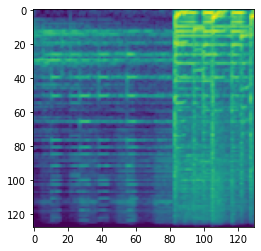

In [ ]:
file="/content/trendy_summer.mp3"
convert_mp3_to_wav(file)
extract("music_file.wav",40,50)
create_melspectrogram("extracted.wav")
image_data = tf.keras.utils.load_img('melspectrogram.png',color_mode='rgba',target_size=(288,432))
class_label,prediction = predict(image_data,model)
print("The Genre of Song is ",class_labels[class_label])

In [ ]:
def create_melspectrogram(wav_file):
  y,sr = librosa.load(wav_file,duration=3)
  mels = librosa.feature.melspectrogram(y=y,sr=sr)
  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
  plt.savefig('melspectrogram2.png')

1/1 [==============================] - 0s 56ms/step
The Genre of Song is  classical


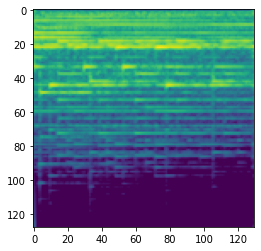

In [ ]:
file2="/content/emotional_uplift.mp3"
convert_mp3_to_wav(file2)
extract("music_file.wav",40,50)
create_melspectrogram("extracted.wav")
image_data = tf.keras.utils.load_img('melspectrogram2.png',color_mode='rgba',target_size=(288,432))
class_label,prediction = predict(image_data,model)
print("The Genre of Song is ",class_labels[class_label])

In [ ]:
def create_melspectrogram(wav_file):
  y,sr = librosa.load(wav_file,duration=3)
  mels = librosa.feature.melspectrogram(y=y,sr=sr)
  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
  plt.savefig('melspectrogram3.png')

1/1 [==============================] - 0s 56ms/step
The Genre of Song is  metal


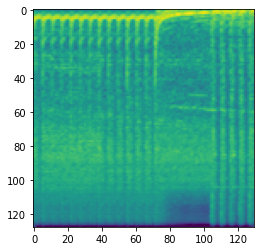

In [ ]:
file3="/content/deadite_ash.mp3"
convert_mp3_to_wav(file3)
extract("music_file.wav",40,50)
create_melspectrogram("extracted.wav")
image_data = tf.keras.utils.load_img('melspectrogram3.png',color_mode='rgba',target_size=(288,432))
class_label,prediction = predict(image_data,model)
print("The Genre of Song is ",class_labels[class_label])

In [ ]:
def create_melspectrogram(wav_file):
  y,sr = librosa.load(wav_file,duration=3)
  mels = librosa.feature.melspectrogram(y=y,sr=sr)
  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
  plt.savefig('melspectrogram4.png')

1/1 [==============================] - 0s 65ms/step
The Genre of Song is  rock


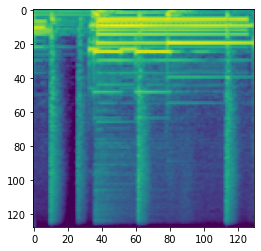

In [ ]:
file3="/content/blues_for_two.mp3"
convert_mp3_to_wav(file3)
extract("music_file.wav",40,50)
create_melspectrogram("extracted.wav")
image_data = tf.keras.utils.load_img('melspectrogram4.png',color_mode='rgba',target_size=(288,432))
class_label,prediction = predict(image_data,model)
print("The Genre of Song is ",class_labels[class_label])

In [ ]:
def create_melspectrogram(wav_file):
  y,sr = librosa.load(wav_file,duration=3)
  mels = librosa.feature.melspectrogram(y=y,sr=sr)
  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
  plt.savefig('melspectrogram5.png')

1/1 [==============================] - 0s 53ms/step
The Genre of Song is  rock


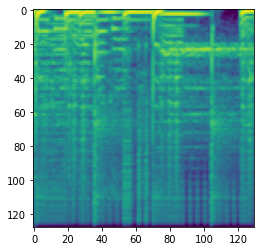

In [ ]:
file4="/content/wake-up-126038.mp3"
convert_mp3_to_wav(file4)
extract("music_file.wav",40,50)
create_melspectrogram("extracted.wav")
image_data = tf.keras.utils.load_img('melspectrogram4.png',color_mode='rgba',target_size=(288,432))
class_label,prediction = predict(image_data,model)
print("The Genre of Song is ",class_labels[class_label])